In [26]:
import glob
import plt

quic_files = glob.glob("quicly*log")

tcp_files = ["tcp-client.pcap", "tcp-server.pcap"]
tcp13_files = ["tcp-client1.3.pcap", "tcp-server1.3.pcap"]
      
vpn_files = glob.glob("openvpn-*")
tcp_csv_files = glob.glob("tcp*csv")
vpn_csv_files = glob.glob("vpn*csv")

print(quic_files)
print(vpn_files)
print(tcp_files)

['quicly-server.log', 'quicly-client.log']
['openvpn-server.pcap', 'openvpn-client.pcap', 'openvpn-client1.3.pcap']
['tcp-client.pcap', 'tcp-server.pcap']


In [27]:
import json

#artificial_start should be set to the first timestamp from the client log,
#when analysing server files only
def get_pn_over_time(file, direction, artificial_start=None):
    q_s_points = []
    with open(file) as w:
        if not artificial_start:
            first = True
            for line in w:
                line = json.loads(line)
                if first:
                    first_time = line["time"]
                    first= False
                if line["type"]==direction:
                    q_s_points.append((line["pn"], line["time"] - first_time))
        else:
            for line in w:
                line = json.loads(line)
                if line["type"]==direction:
                    q_s_points.append((line["pn"], line["time"] - artificial_start))
    return q_s_points

    

In [28]:


def get_sn_over_time(file, direction, mss):
    tcp_points={}
    tcp_points["forward"] = []
    tcp_points["reverse"] = []
    first = True
    first_forward = True
    first_rev = True
    tr = plt.trace(file)
    tr.start()
    for pkt in tr:
        if pkt.tcp:
            if first:
                first_time = pkt.seconds*1000

                first = False
            if pkt.tcp.dst_port == 443:
                if first_forward:
                    forward_sn = pkt.tcp.seq_nbr
                    first_forward = False
                tcp_points["forward"].append(((pkt.tcp.seq_nbr - forward_sn)/mss, pkt.seconds*1000 - first_time))
            else:
                if first_rev:
                    rev_sn = pkt.tcp.seq_nbr
                    first_rev = False                
                tcp_points["reverse"].append(((pkt.tcp.seq_nbr - rev_sn)/mss, pkt.seconds*1000 - first_time))
    
    return tcp_points[direction]


In [29]:
import matplotlib.pyplot as mplt
from matplotlib.pyplot import figure
from matplotlib.dates import DateFormatter
from collections import defaultdict
import numpy as np
import datetime
from pylab import *


def mjrFormatter(x, pos):
    s, ms = divmod(x, 1000)
    return "{:01d}.{:01d}".format(int(s),int(ms))


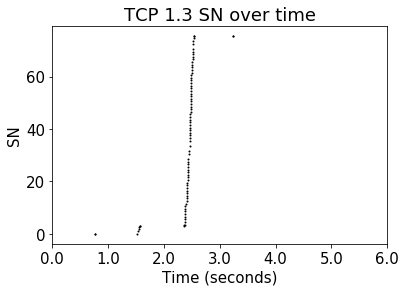

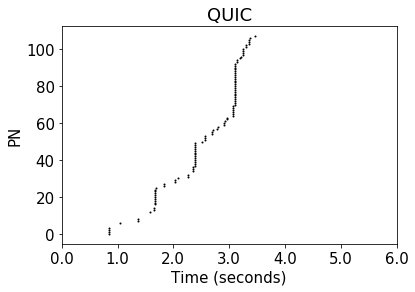

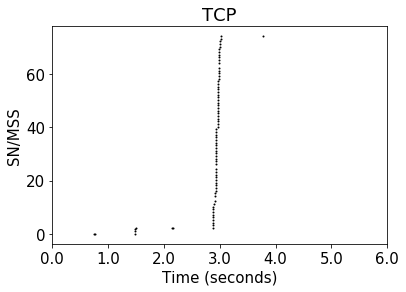

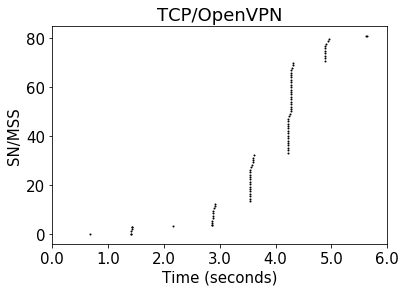

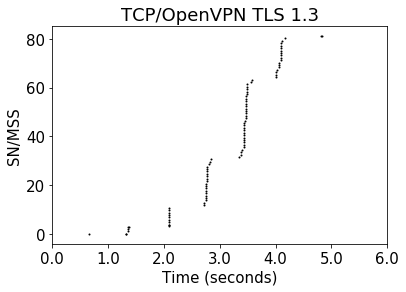

In [30]:
import plt

a, b = zip(*(get_sn_over_time("tcp-client1.3.pcap", "reverse", 1460)))

ax = mplt.subplot()
matplotlib.rcParams.update({'font.size': 15})

ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter))

mplt.title("TCP 1.3 SN over time")
mplt.ylabel('SN')
mplt.xlabel('Time (seconds)')

mplt.plot(b, a, 'go-', linewidth=0.0, markersize=1, color="black")
ax.set_xlim(0,6000)

mplt.show()


a, b = zip(*(get_pn_over_time("quicly-client.log", "quictrace-recv")))

ax = mplt.subplot()
matplotlib.rcParams.update({'font.size': 15})

ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter))

mplt.title("QUIC")
mplt.ylabel('PN')
mplt.xlabel('Time (seconds)')

mplt.plot(b, a, 'go-', linewidth=0.0, markersize=1, color="black")
ax.set_xlim(0,6000)

mplt.show()


a, b = zip(*(get_sn_over_time("tcp-client.pcap", "reverse", 1460)))
ax = mplt.subplot()
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter))
mplt.title("TCP")
mplt.ylabel('SN/MSS')
mplt.xlabel('Time (seconds)')
mplt.plot(b, a, 'go-', linewidth=0.0, markersize=1, color="black")
ax.set_xlim(0,6000)

mplt.show()


a, b = zip(*(get_sn_over_time("openvpn-client.pcap", "reverse", 1358)))
ax = mplt.subplot()
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter))
mplt.title("TCP/OpenVPN")
mplt.ylabel('SN/MSS')
mplt.xlabel('Time (seconds)')
mplt.plot(b, a, 'go-', linewidth=0.0, markersize=1, color="black")
ax.set_xlim(0,6000)

mplt.show()

a, b = zip(*(get_sn_over_time("openvpn-client1.3.pcap", "reverse", 1358)))
ax = mplt.subplot()
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter))
mplt.title("TCP/OpenVPN TLS 1.3")
mplt.ylabel('SN/MSS')
mplt.xlabel('Time (seconds)')
mplt.plot(b, a, 'go-', linewidth=0.0, markersize=1, color="black")
ax.set_xlim(0,6000)

mplt.show()



In [31]:
import csv

def get_rtts_and_times(file, destinations):
    latrtt = []
    minrtt = []
    smoothrtt = []
    cwnd = []
    if file.startswith("quic"):
        with open(file) as w:
            first = True
            for line in w:
            #print(line)
                line = json.loads(line)
                if first:
                    first_time = line["time"]
                    first= False
                if line["type"]=="quictrace-cc-ack":
                    latrtt.append((line["latest-rtt"], line["time"] - first_time))
                    minrtt.append((line["min-rtt"], line["time"] - first_time))
                    smoothrtt.append((line["latest-rtt"], line["time"] - first_time))            
                    cwnd.append((line["cwnd"], line["time"] - first_time))
                else:
                    if line["type"] in ["pto", "cc-ack-received"]:
                        cwnd.append((line["cwnd"], line["time"] - first_time))


                        
    else:
        with open(file) as csvfile:
            first = True
            reader = csv.DictReader(csvfile)
            for row in reader:
                if first:
                    first_time_tcp = float(row["Time"])
                    first= False
                if row["ack_rtt"] and row["Destination"] in destinations:
                    latrtt.append((float(row["ack_rtt"])*1000, (float(row["Time"])-first_time_tcp)*1000))
                if row["wsize"] and row["Destination"] in destinations:
                    cwnd.append((row["wsize"], (float(row["Time"])-first_time_tcp)*1000))
        latrtt = latrtt[1:]
            
    return latrtt, minrtt, smoothrtt, cwnd



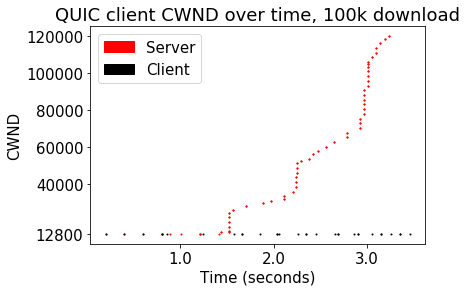

In [9]:

import matplotlib.patches as mpatches
color={}
color["quicly-server.log"]="red"
color["quicly-client.log"]="black"
for f in quic_files:
    qlatrtt, qminrtt, qsmoothrtt, qcwnd = get_rtts_and_times(f, [])
    a,b = zip(*qcwnd)
    ax = mplt.subplot()
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter))
    mplt.title('QUIC client CWND over time, 100k download')
    mplt.ylabel('CWND')
    mplt.xlabel('Time (seconds)')
    mplt.yticks([12800,40000,60000, 80000, 100000, 120000])

    mplt.plot(b, a, 'go', markersize=1, linewidth=0.1, color=color[f])

    red_patch = mpatches.Patch(color='red', label='Server')
    black_patch = mpatches.Patch(color='black', label='Client')
    mplt.legend(handles=[red_patch, black_patch])
mplt.show()



In [34]:

server_destinations =["137.50.19.227", "137.50.19.137"]
client_destinations = ["10.8.0.6", "192.168.121.214", "88.210.175.226"]


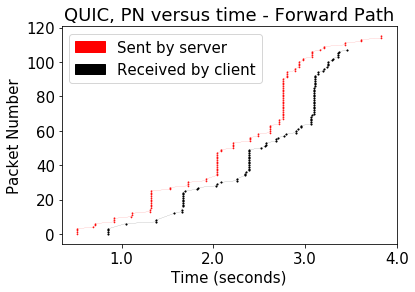

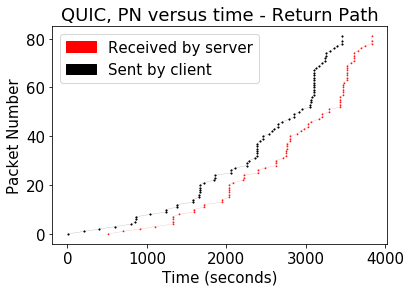

In [35]:
import matplotlib.patches as mpatches

        

ax = mplt.subplot()
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter))
mplt.title("QUIC, PN versus time - Forward Path")
mplt.ylabel('Packet Number')
mplt.xlabel('Time (seconds)')


a,b = zip(*get_pn_over_time("quicly-server.log", "quictrace-sent", 1562687190400))
mplt.plot(b, a, 'gv-', linewidth=0.1, markersize=1, color="red")
a,b = zip(*get_pn_over_time("quicly-client.log", "quictrace-recv"))
mplt.plot(b, a, 'gD-', linewidth=0.1, markersize=1, color="black")
red_patch = mpatches.Patch(color='red', label='Sent by server')
black_patch = mpatches.Patch(color='black', label='Received by client')
mplt.legend(handles=[red_patch, black_patch])
mplt.show()


a,b = zip(*get_pn_over_time("quicly-server.log", "quictrace-recv", 1562687190400))
mplt.plot(b, a, 'gv-', linewidth=0.1, markersize=1, color="red")
a,b = zip(*get_pn_over_time("quicly-client.log", "quictrace-sent"))

mplt.title("QUIC, PN versus time - Return Path")
mplt.ylabel('Packet Number')
mplt.xlabel('Time (seconds)')
mplt.plot(b, a, 'gD-', linewidth=0.1, markersize=1, color="black")
red_patch = mpatches.Patch(color='red', label='Received by server')
black_patch = mpatches.Patch(color='black', label='Sent by client')
mplt.legend(handles=[red_patch, black_patch])
mplt.show()



    #print(get_pn_over_time(file, "quictrace-sent"))
    

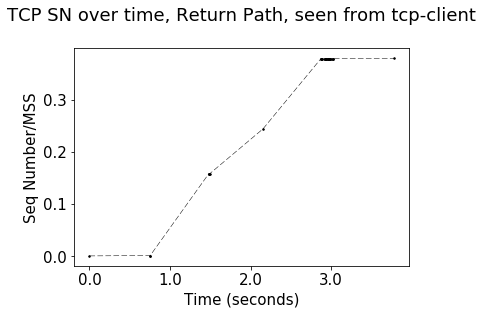

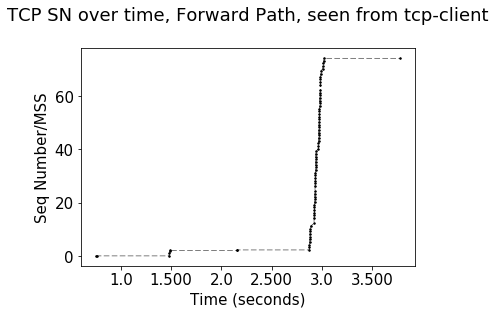

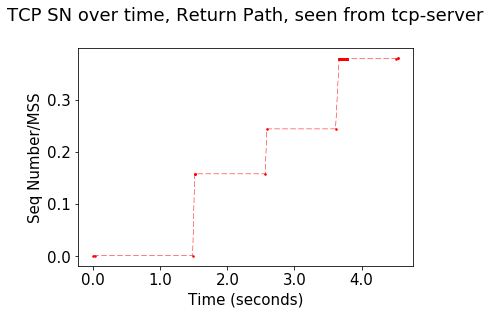

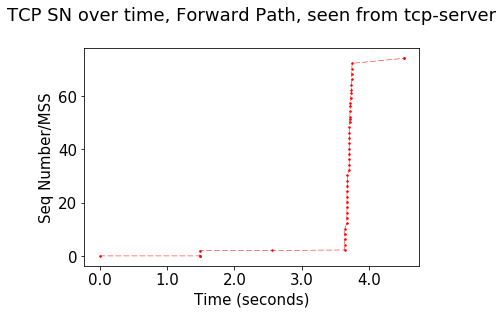

In [36]:
import plt
color = {}
color["tcp-server"] = "red"
color["tcp-client"] = "black"
for file in tcp_files:
    #print(get_sn_over_time(file, "forward"))
    #break
    for direction in ["forward", "reverse"]:
        if direction == "reverse":
            d = "Forward"
            a, b  = zip(*(get_sn_over_time(file, direction,1460)))
        else:
            a, b  = zip(*(get_sn_over_time(file, direction, 1460)))
            d = "Return"

        name = file.strip(".pcap")
        ax = mplt.subplot()
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter))
        mplt.title("TCP SN over time, {} Path, seen from {}".format(d, name), y=1.1)
        mplt.ylabel('Seq Number/MSS')
        mplt.xlabel('Time (seconds)')
        mplt.plot(b, a, 'go--', linewidth=0.5, markersize=1.5, color=color[name])
        mplt.show()


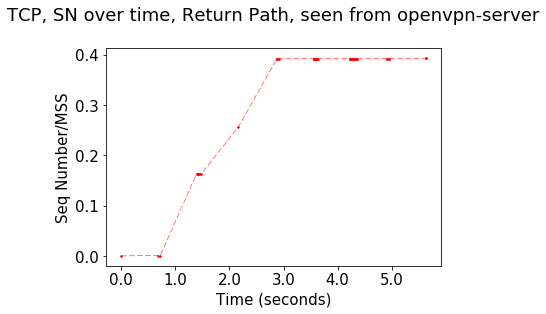

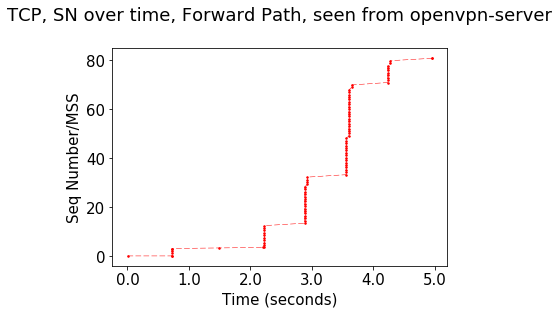

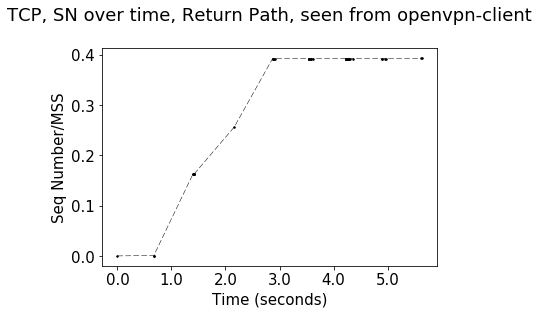

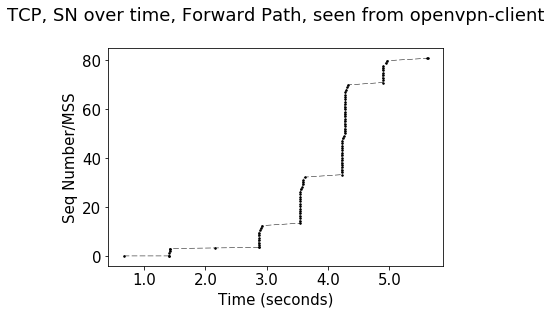

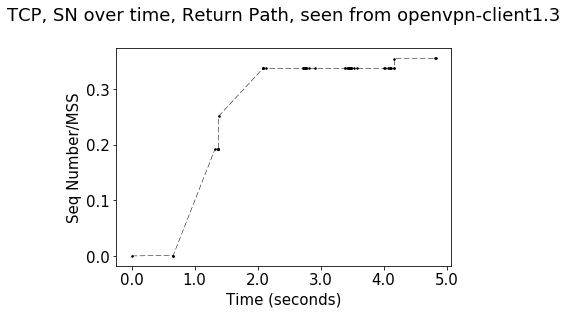

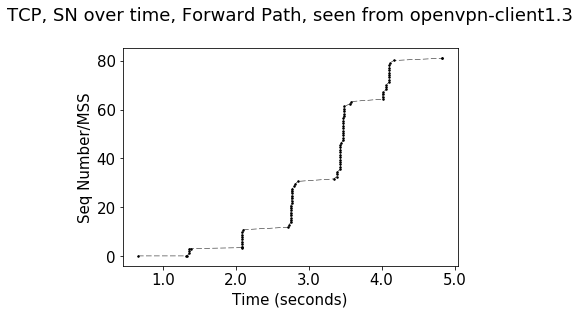

In [37]:
import plt
color = {}
color["openvpn-server"] = "red"
color["openvpn-client"] = "black"
color["openvpn-client1.3"] = "black"
for file in vpn_files:
    #print(get_sn_over_time(file, "forward"))
    #break
    for direction in ["forward", "reverse"]:
        if direction != "forward":
            a, b  = zip(*(get_sn_over_time(file, direction,1358)))
            d = "Forward"
        else:
            a, b = zip(*(get_sn_over_time(file, direction, 1358)))
            d = "Return"
        name = file.strip(".pcap")
        ax = mplt.subplot()
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter))
        mplt.title("TCP, SN over time, {} Path, seen from {}".format(d, name), y=1.1)
        mplt.ylabel('Seq Number/MSS')
        mplt.xlabel('Time (seconds)')
        mplt.plot(b, a, 'go--', linewidth=0.5, markersize=1.5, color=color[name])
        mplt.show()



In [19]:

server_files = tcp_csv_files 
server_files.extend(vpn_csv_files)
client_files = [ x for x in server_files if "client" in x]
server_files = [ x for x in server_files if "server" in x]


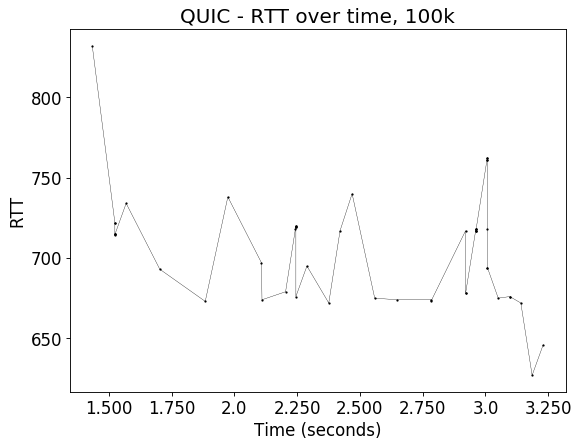

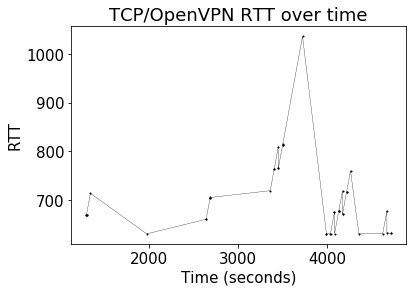

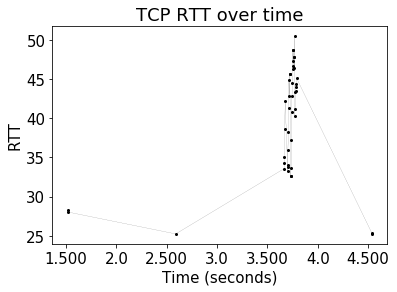

In [20]:
import matplotlib.patches as mpatches

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

qlatrtt, qminrtt, qsmoothrtt, qcwnd = get_rtts_and_times('quicly-server.log', [])
a,b = zip(*qlatrtt)
ax = mplt.subplot()
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter))
mplt.title('QUIC - RTT over time, 100k')

mplt.ylabel('RTT')
mplt.xlabel('Time (seconds)')
mplt.plot(b, a, 'go-', markersize=1, linewidth=0.3, color='black')
mplt.show()
mplt.title('TCP/OpenVPN RTT over time')


ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter))


qlatrtt, qminrtt, qsmoothrtt, qcwnd = get_rtts_and_times('vpnserver.csv', server_destinations)
a,b = zip(*qlatrtt)
mplt.ylabel('RTT')
mplt.xlabel('Time (seconds)')
mplt.plot(b, a, 'go-', markersize=1, linewidth=0.3, color='black')

mplt.show()

server_destinations =["137.50.19.227", "137.50.19.137"]
client_destinations = ["10.8.0.6", "192.168.121.214", "88.210.175.226"]

qlatrtt, qminrtt, qsmoothrtt, qcwnd = get_rtts_and_times('tcpserver.csv', server_destinations)
a,b = zip(*qlatrtt)
ax = mplt.subplot()
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter))
mplt.title('TCP RTT over time')
mplt.ylabel('RTT')
mplt.xlabel('Time (seconds)')
mplt.plot(b, a, 'go-', markersize=2, linewidth=0.1, color='black')

mplt.show() 

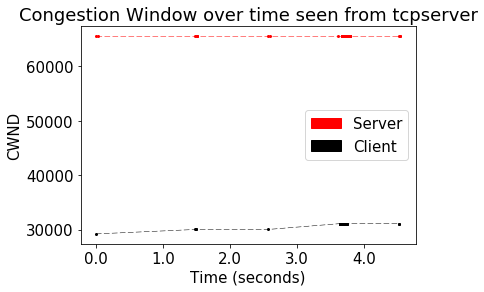

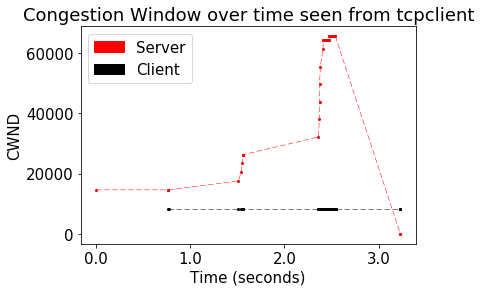

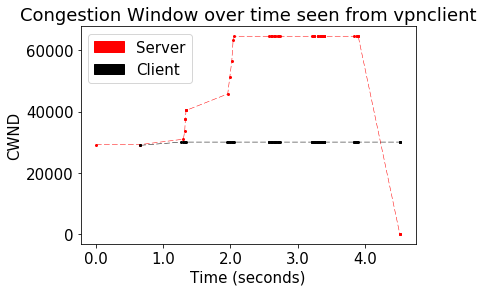

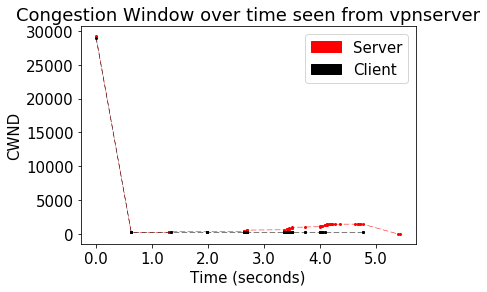

In [23]:
import matplotlib.patches as mpatches
for file in tcp_csv_files:
    try:
        #print(file)
        qlatrtt, qminrtt, qsmoothrtt, qcwnd = get_rtts_and_times(file, server_destinations)
        #print(qcwnd)
        a,b = zip(*qcwnd)
        ax = mplt.subplot()                     
        name = file.strip('.csv')
        if name.startswith("pn"):
            name = "v" + name
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter))
        mplt.title('Congestion Window over time seen from {}'.format(name))
        mplt.ylabel('CWND')
        mplt.xlabel('Time (seconds)')
        mplt.plot(b, a, 'go--', markersize=2, linewidth=0.5, color='red')
        qlatrtt, qminrtt, qsmoothrtt, qcwnd = get_rtts_and_times(file, client_destinations)
        #mplt.show()
        a,b = zip(*qcwnd)
        mplt.plot(b, a, 'go--', markersize=2, linewidth=0.5, color='black')
        red_patch = mpatches.Patch(color='red', label='Server')
        black_patch = mpatches.Patch(color='black', label='Client')
        mplt.legend(handles=[red_patch, black_patch])
        mplt.show()
    except Exception as e:
        print(e)